## 6.4.3 卷积神经网络实例
### 1. 实例1 CNN分类Fashion MNIST数据集
&emsp;&emsp;**例6-4-4** 利用Keras构建卷积神经网络模型对Fashion MNIST数据集进行分类。Fashion MNIST数据集包含大小为28*28、分为10个类别的60000张灰色图像和同样是大小28*28、分为10个类别的10000张灰色图像的测试集，其类别标签与图像所表示的服装类别对应关系如表6-4-1所示。

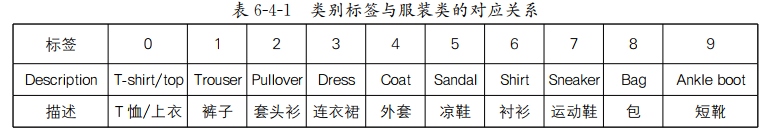

&emsp;&emsp;利用Keras构建卷积神经网络模型时主要涉及的步骤为，载入数据，对该数据预处理，构建Sequential模型，构建神经网络和全连接层，利用compile函数进行编译，利用fit函数训练模型，最后进行模型的评估和对新数据的预测，所用的代码如下所示。

&emsp;&emsp;本程序与6.3节完整版程序（fl6-3-2-2）的主体基本一致，增加或修改的代码见标注。

#### （1）导入外部库和Fashion-MNIST数据集
&emsp;&emsp;通过import导入TensorFlow库、导入matplotlib.pyplot用于的绘图，导入sklearn库的metrics模块用于计算混淆矩阵(Confusion Matrix)，利用keras 的load_data()函数载入Fashion-MNIST数据集。首次载入数据集时，如果文件下没有Fashion-MNIST数据集，程序会自动下载，但可能花费较久时间，因此可以将“配套资源\第6章\datasets\Fashion-MNIST”复制到该文件夹下，避免额外的数据集载入时间。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#### （2）查看训练集和测试集的形状
&emsp;&emsp;该段代码是对数据集的进行探索，表明Fashion MNIST数据集中训练集包含60000张大小为28*28的图像和测试集包含10000张大小为28*28的图像的。

In [2]:
print('The shape of train data=',X_train.shape)
print('The shape of y_train:',y_train.shape)
print('The shape of test data=',X_test.shape)
print('The shape of y_test:',y_test.shape)

The shape of train data= (60000, 28, 28)
The shape of y_train: (60000,)
The shape of test data= (10000, 28, 28)
The shape of y_test: (10000,)


#### （3）建立映射表
&emsp;&emsp;该段代码是信息参考表6-4-1映射图像与类别标签的关系，从而方便后续使用。

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', \
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### （4）显示训练集的前20个图像和标签
&emsp;&emsp;结合代码段(3)查看训练集前20个数据的特征和标签，显示图像与类别标签的对应关系，

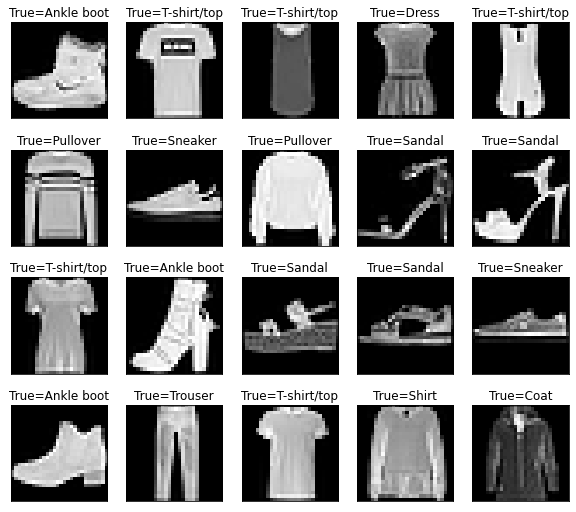

In [4]:
plt.figure(figsize=(10,9))
num=20
for i in range(0, num):
    plt.subplot(4,5,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("True="+str(class_names[y_train[i]]))
plt.show()

#### （5）利用reshape函数转换数字图像
&emsp;&emsp;利用reshape()函数修改训练集和测试集的形状，从而进行后续的卷积神经网络模型的训练。

In [5]:
X_train_reshape = X_train.reshape(X_train.shape[0],28,28,1)                    #增加/修改代码
X_test_reshape = X_test.reshape(X_test.shape[0],28,28,1)                       #增加/修改代码

#### （6）查看经过reshape之后训练集和测试集的形状
&emsp;&emsp;将原训练集和测试集的形状(60000, 28, 28)利用reshape()函数转换为(60000, 28, 28, 1)，(10000, 28, 28, 1)，方便输入到卷积神经网络模型中。

In [6]:
print('The shape of train reshape data=',X_train_reshape.shape)
print('The shape of y_train:',y_train.shape)
print('The shape of test reshape data=',X_test_reshape.shape)
print('The shape of y_train:',y_test.shape)

The shape of train reshape data= (60000, 28, 28, 1)
The shape of y_train: (60000,)
The shape of test reshape data= (10000, 28, 28, 1)
The shape of y_train: (10000,)


#### （7）归一化数字图像
&emsp;&emsp;数字图像的像素值分布范围是0~255，可以简单的通过同除以255来实现归一化。

In [7]:
X_train_norm, X_test_norm = X_train_reshape / 255.0, X_test_reshape / 255.0

####  （8）构建Sequential模型
&emsp;&emsp;该行代码是实例化一个Sequential模型

In [8]:
model = tf.keras.models.Sequential()

#### （9）构造卷积神经网络
&emsp;&emsp;该段代码通过添加卷积层、池化层和Dropout层来构建卷积神经网络模型。

&emsp;&emsp;以下补充介绍添加Conv2D()函数、MaxPooling2D()函数、Dropout()函数。

* Conv2D()函数

&emsp;&emsp;Conv2D()函数为构建2D卷积层，其一般形式为：

&emsp;&emsp;tf.keras.layers.Conv2D(filters, kernel_size, strides, padding, activation, input_shape)

&emsp;&emsp;相关参数解释如下：

&emsp;&emsp;&emsp;&emsp;Filters：输出空间的维数，即卷积中的滤波器数，神经网络的神经元个数；本例中32表示有32个滤波器，即有该层有32个神经元；

&emsp;&emsp;&emsp;&emsp;kernel_size：单整数或2个整数的元组或列表，表示2D卷积窗口的高度和宽度，若为单整数，高度和宽度相同。本例中的(3, 3)表示卷积核的大小为3*3；

&emsp;&emsp;&emsp;&emsp;strides：单整数或2个整数的元组或列表，表示卷积沿高度和宽度的步长，若为单整数，沿高度和宽度的步长相同，默认为(1,1)；

&emsp;&emsp;&emsp;&emsp;padding：可以是"valid"或"same"(不区分大小写)，默认为"valid"；

&emsp;&emsp;&emsp;&emsp;activation：激活函数，若未指定，则不应用激活函数；

&emsp;&emsp;&emsp;&emsp;input_shape：当作为模型的第一层时，需要指定该参数。如input_shape=(28, 28, 1)表示输入的是28*28的灰度图像，而非6.3节完整版程序（fl6-3-2-2）的28*28=784个神经元。

* MaxPooling2D()函数

&emsp;&emsp;MaxPooling2D()函数用于构建2D池化层，其一般形式为：

&emsp;&emsp;tf.keras.layers.MaxPool2D(pool_size, strides, padding)

&emsp;&emsp;相关参数解释如下：

&emsp;&emsp;&emsp;&emsp;pool_size：单整数或2个整数的元组或列表，表示池化窗口大小，若为单整数，则所有维度相同，默认为(2,2)；

&emsp;&emsp;&emsp;&emsp;strides：步长，类似Conv2D()函数中strides；

&emsp;&emsp;&emsp;&emsp;padding：表示填充方法，类似Conv2D()函数中padding，当为"same"时，在卷积时边缘由0填充，导致卷积前后图像大小一致。

* Dropout()函数

&emsp;&emsp; Dropout()函数作用是在本次训练时随机的忽略一定比例的神经元，从而可以在一定程度上缓解过拟合现象的发生，其一般形式为：

&emsp;&emsp;tf.keras.layers.Dropout(rate)

&emsp;&emsp;其中，rate表示退出率，取值范围为0~1。

In [9]:
#构建卷积层
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))          #增加/修改代码
#构建池化层
model.add(tf.keras.layers.MaxPooling2D((2, 2)))                                                    #增加/修改代码
#构建Dropout层
model.add(tf.keras.layers.Dropout(rate=0.2))                                                       #增加/修改代码

#### （10）构建全连接层
&emsp;&emsp;该段代码是构建全连接层用于分类，首先利用Flatten()函数将输入数据的维度拉伸成一维，然后添加了一个包含50个神经元的全连接层，最后添加10个神经元输出层，对应Fashion-MNIST数据集的10个类别，因为是多分类问题，所以activation='softmax'。其中，Flatten()函数作用是将上一层的维度拉伸成一维向量，与reshape()函数功能类似，一般在出现在卷积神经网络的末端。

In [10]:
model.add(tf.keras.layers.Flatten())                                                              #增加/修改代码
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense((10),activation='softmax'))

#### （11）打印模型的概况

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                270450    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 271,280
Trainable params: 271,280
Non-trainable params: 0
__________________________________________________

#### （12）模型编译
&emsp;&emsp;该段代码主要利用model.compile()函数实现模型的编译。

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

####  （13）模型训练
&emsp;&emsp;该段代码主要利用model.fit()函数实现模型的训练。

In [13]:
history = model.fit(X_train_norm, y_train, validation_split=0.2, epochs=10, verbose=1)        #增加/修改代码

Epoch 1/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.6214 - accuracy: 0.7836 - val_loss: 0.3548 - val_accuracy: 0.8739
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3260 - accuracy: 0.8842 - val_loss: 0.3050 - val_accuracy: 0.8911
Epoch 3/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2792 - accuracy: 0.8996 - val_loss: 0.2890 - val_accuracy: 0.8966
Epoch 4/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2541 - accuracy: 0.9056 - val_loss: 0.2775 - val_accuracy: 0.8966
Epoch 5/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2297 - accuracy: 0.9179 - val_loss: 0.2519 - val_accuracy: 0.9107
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2034 - accuracy: 0.9257 - val_loss: 0.2568 - val_accuracy: 0.9088
Epoch 7/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1924 - accuracy: 0.9277 - val_loss: 0.2516 - val_ac

####  （14）模型评估
&emsp;&emsp;模型训练后，使用测试集数据，利用model.evaluate()函数对模型进行评估。

In [14]:
model.evaluate(X_test_norm, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.2685 - accuracy: 0.9130


[0.2684684097766876, 0.9129999876022339]

#### （15）模型预测
&emsp;&emsp;模型训练好后，利用model.predict_classes()函数进行预测，本步利用经归一化后的测试集图像进行预测。

In [18]:
prediction=model.predict_classes(X_test_norm)

####  （16）显示测试集的前20个图像的预测类别和真实类别
&emsp;&emsp;为了便于查看预测效果和保存模型，该段代码来显示测试集的前20个图像的预测类别和真实类别。

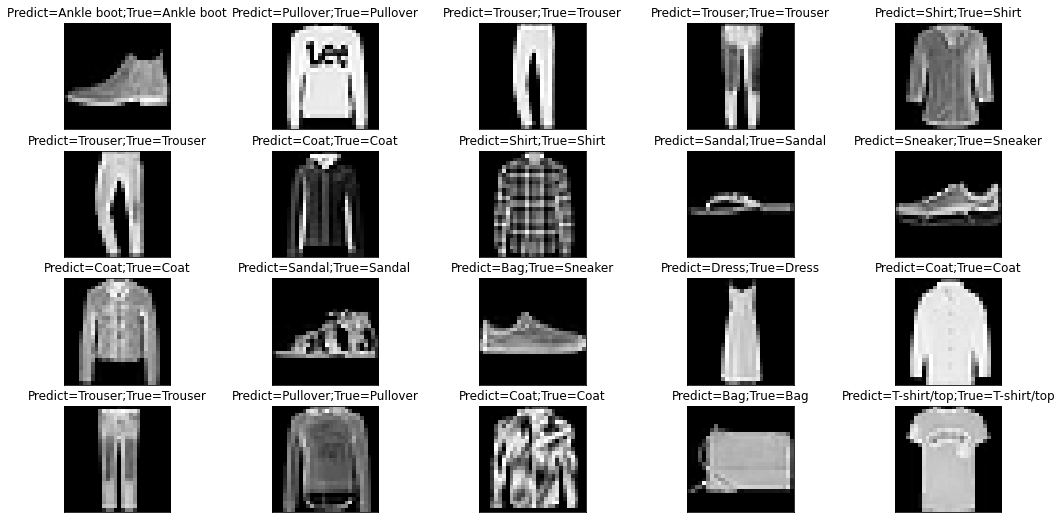

In [16]:
plt.figure(figsize=(18,9))
num=20
for i in range(0, num):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("Predict="+str(class_names[prediction[i]]) +";True=" + str(class_names[y_test[i]]))
plt.show()

####  （17）计算混淆矩阵
&emsp;&emsp;为了更好的理解卷积神经网络模型对测试集不同类别图像的分类正确率，总结分类效果的相关信息，可以通过计算混淆矩阵(Confusion Matrix)的方法来实现。利用sklearn中的confusion_matrix()函数对y_test和prediction计算混淆矩阵。

In [17]:
print('Confusion Matrix：')
print(metrics.confusion_matrix(y_test, prediction))

Confusion Matrix：
[[857   0  12  35   6   1  85   0   4   0]
 [  1 977   0  16   3   0   2   0   1   0]
 [ 19   1 839  12  62   0  66   0   1   0]
 [ 10   2   8 940  15   0  23   0   2   0]
 [  0   1  40  35 873   0  48   0   3   0]
 [  0   0   0   0   0 979   0  13   1   7]
 [ 96   0  37  33  70   0 755   0   9   0]
 [  0   0   0   0   0   6   0 980   1  13]
 [  5   1   2   5   3   1   6   5 972   0]
 [  0   0   0   0   0   7   1  34   0 958]]


&emsp;&emsp;由混淆矩阵可知，该混淆矩阵元素总和为10000，对应测试集中的10000个图像。位于对角线部分的数字是被正确预测的图像的数量，比如位于四行四列的939表示真实值为连衣裙，预测值也为连衣裙的图像数目，四行五列的25表示真实值为连衣裙，预测错误，预测值为外套的图像数目，五行四列的32表示真实值为外套，预测错误，预测值为连衣裙的图像数目。

### 2. 实例2 CNN分类CIFAR10数据集
&emsp;&emsp;**例6-4-5** 利用Keras构建卷积神经网络模型对CIFAR10数据集进行分类。CIFAR10数据集总共有60000张大小为32*32的三通道彩色图像，被分为10个类，其中50000张作为训练集，10000作为测试集。类别标签与图像所代表类别的对应关系如表6-4-2所示。

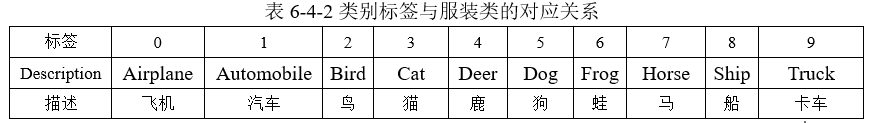

&emsp;&emsp;利用keras构建卷积神经网络模型时主要涉及的步骤为，载入数据，对该数据预处理，构建Sequential模型，构建神经网络和全连接层，利用compile函数进行编译，利用fit函数训练模型，最后进行模型的评估和对新数据的预测。所用的代码如下所示：

#### （1）导入外部库和CIFAR10数据集
&emsp;&emsp;通过import导入TensorFlow库、导入matplotlib.pyplot为之后的绘图，导入sklearn库的metrics模块用于计算混淆矩阵(Confusion Matrix)，利用Keras的load_data()函数载入CIFAR10数据集。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### （2）查看训练集和测试集的形状
&emsp;&emsp;该段代码是对数据集的进行探索，表明CIFAR10数据集中训练集包含60000张大小为32*32的彩色图像和测试集包含10000张大小为32*32的彩色图像，注意与Fashion-MNIST数据集的区别，此处就不需要再用利用reshape()函数修改训练集和测试集的形状，而由于标签数据是两维的数据，所以在画图程序有所不同。

In [2]:
print('The shape of train data=',X_train.shape)
print('The shape of y_train:',y_train.shape)
print('The shape of test data=',X_test.shape)
print('The shape of y_test:',y_test.shape)

The shape of train data= (50000, 32, 32, 3)
The shape of y_train: (50000, 1)
The shape of test data= (10000, 32, 32, 3)
The shape of y_test: (10000, 1)


#### （3）建立映射表
&emsp;&emsp;该段代码是信息参考表6-4-2映射图像与类别标签的关系，从而方便后续使用。

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#### （4）显示训练集的前20个图像和标签
&emsp;&emsp;结合代码段(3)查看训练集前20个数据的特征和标签，显示图像与类别标签的对应关系

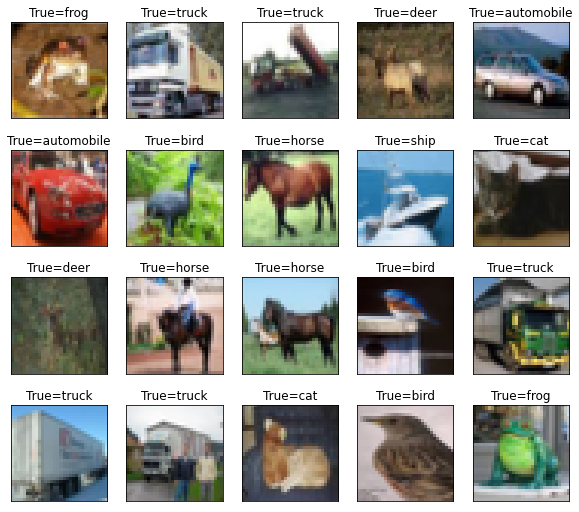

In [4]:
plt.figure(figsize=(10,9))
num=20
for i in range(0, num):
    plt.subplot(4,5,i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("True="+str(class_names[y_train[i][0]]))
plt.show()

#### （5）归一化数字图像
&emsp;&emsp;由于数字图像的像素值取值在0到255之间，所以可以通过同除以255来实现归一化。

In [5]:
X_train_norm, X_test_norm = X_train / 255.0, X_test / 255.0

#### （6）构建Sequential模型
&emsp;&emsp;该行代码是实例化一个Sequential模型。

In [6]:
model = tf.keras.models.Sequential()

#### （7）构造卷积神经网络
&emsp;&emsp;该段代码通过添加两层卷积层、两层池化层和一层Dropout层来构建卷积神经网络。其中，第一层卷积层的滤波器个数为32个，卷积核尺寸为3*3，激活函数为relu函数，input_shape=(32, 32, 3)表明输入的32*32的三通道彩色图像数据，第二层卷积层的滤波器个数为64个，卷积核尺寸和激活函数与第一层相同；两层池化层的尺寸皆为2*2。tf.keras.layers.Dropout(rate=0.2)表明在训练时随机忽略总数0.2的神经元，参数的详细解释可参考例6-4-4代码段（9）。

In [7]:
#构建卷积层
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
#构建池化层
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#构建卷积层
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',))
#构建池化层
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#构建Dropout层
model.add(tf.keras.layers.Dropout(rate=0.2))

#### （8）构建全连接层
&emsp;&emsp;该段代码构建全连接层用于分类，首先利用Flatten()函数将输入数据的维度拉伸成一维，然后添加一个包含80个滤波器的全连接层，最后添加10个神经元输出层，由于是多分类问题，所以激活函数选择softmax。

In [8]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(80, activation='relu'))
model.add(tf.keras.layers.Dense((10),activation='softmax'))

#### （9）打印模型的概况

In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 80)                1

#### （10）模型编译
&emsp;&emsp;该段代码主要利用model.compile()函数实现模型的编译.

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### （11）模型训练
&emsp;&emsp;该段代码主要利用model.fit()函数实现模型的训练，选用训练集的10%作为验证集，训练周期为20次.

In [11]:
history = model.fit(X_train_norm, y_train, validation_split=0.1, epochs=20, verbose=1)

Epoch 1/20
1407/1407 [==============================] - 27s 19ms/step - loss: 1.7050 - accuracy: 0.3723 - val_loss: 1.1942 - val_accuracy: 0.5734
Epoch 2/20
1407/1407 [==============================] - 25s 18ms/step - loss: 1.1629 - accuracy: 0.5920 - val_loss: 1.0293 - val_accuracy: 0.6332
Epoch 3/20
1407/1407 [==============================] - 25s 18ms/step - loss: 1.0144 - accuracy: 0.6416 - val_loss: 0.9901 - val_accuracy: 0.6576
Epoch 4/20
1407/1407 [==============================] - 25s 18ms/step - loss: 0.9354 - accuracy: 0.6740 - val_loss: 0.9297 - val_accuracy: 0.6802
Epoch 5/20
1407/1407 [==============================] - 27s 19ms/step - loss: 0.8620 - accuracy: 0.6977 - val_loss: 0.9415 - val_accuracy: 0.6842
Epoch 6/20
1407/1407 [==============================] - 25s 18ms/step - loss: 0.8131 - accuracy: 0.7139 - val_loss: 0.8481 - val_accuracy: 0.7084
Epoch 7/20
1407/1407 [==============================] - 25s 18ms/step - loss: 0.7554 - accuracy: 0.7369 - val_loss: 0.8378 -

#### （12）模型评估
&emsp;&emsp;模型训练后，使用测试集数据，利用model.evaluate()函数对模型进行评估

In [12]:
model.evaluate(X_test_norm, y_test, verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 1.0046 - accuracy: 0.7051


[1.0045568943023682, 0.7050999999046326]

#### （13）模型预测
&emsp;&emsp;模型训练好后，利用model.predict_classes()函数进行预测，利用经归一化后的测试集图像进行预测。

In [15]:
prediction=model.predict_classes(X_test_norm)

#### （14）显示测试集的前20个图像的预测类别和真实类别
&emsp;&emsp;为了便于查看预测效果和保存模型，该段代码来显示测试集的前20个图像的预测类别和真实类别。

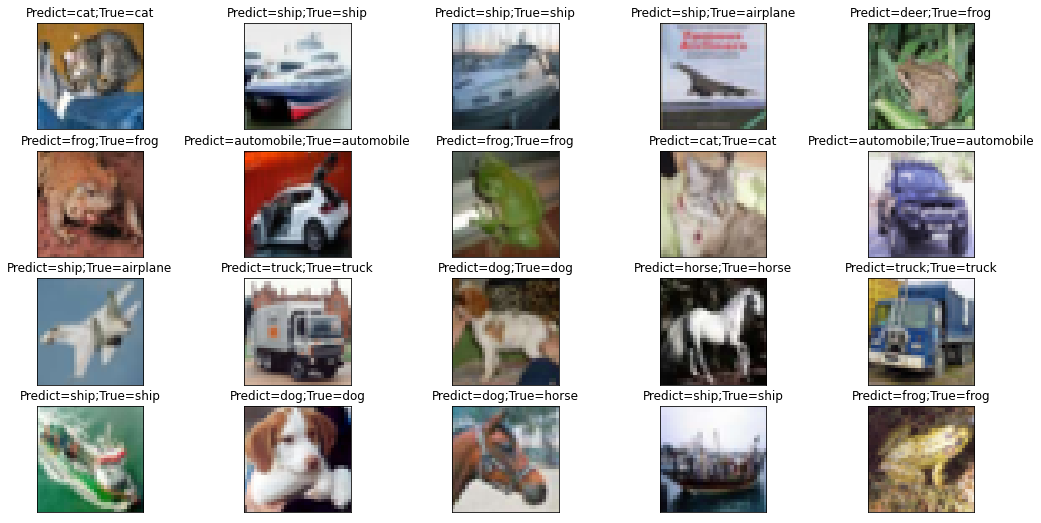

In [18]:
plt.figure(figsize=(18,9))
num=20
for i in range(0, num):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("Predict="+str(class_names[prediction[i]]) +";True=" + str(class_names[y_test[i][0]]))
plt.show()

#### （15）计算混淆矩阵
&emsp;&emsp;该段代码利用混淆矩阵来展示卷积神经网络模型对CIFAR10数据集中不同类别的数据的分类效果。

In [19]:
print('Confusion Matrix：')
print(metrics.confusion_matrix(y_test, prediction))

Confusion Matrix：
[[772  12  28  14  13   5   6   7 110  33]
 [ 23 792   4   6   1   1  10   1  58 104]
 [ 79   9 518  85  94  67  79  24  32  13]
 [ 31  17  59 515  55 154  76  29  35  29]
 [ 21   1  39  78 657  47  63  68  20   6]
 [ 18   7  30 197  37 608  21  48  22  12]
 [ 11   2  35  61  23  26 809   3  21   9]
 [ 29   5  30  42  54  74  10 712  14  30]
 [ 48  16  12  11   9   5   4   2 868  25]
 [ 42  81   8  11   2   3   6   6  41 800]]
